In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Fri Jan 12 17:20:25 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    15W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.sampling_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.12-7/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 37668
-rw-rw-r-- 1 scpark scpark   211556  1월 12 17:20 events.out.tfevents.1705047503.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38023101  1월 12 17:18 save_0
-rw-rw-r-- 1 scpark scpark   334532  1월 12 17:18 events.out.tfevents.1705047312.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


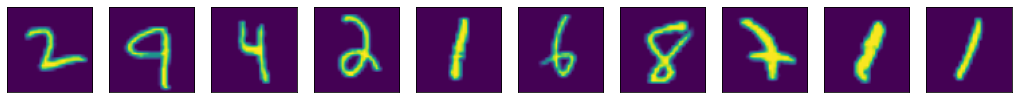

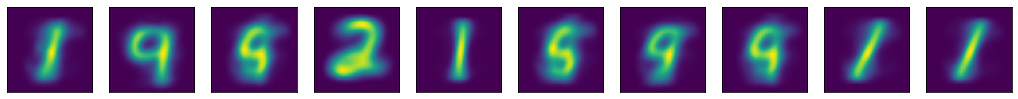

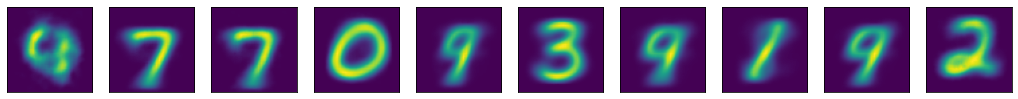

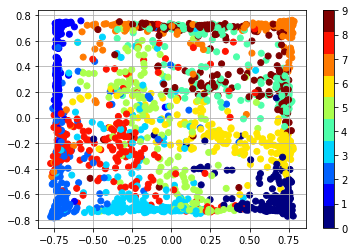

123001
lse_loss -1.9248048067092896
recon_loss 0.16733430325984955
123002
lse_loss -1.9401013851165771
recon_loss 0.178869366645813
123003
lse_loss -1.958890676498413
recon_loss 0.16401897370815277
123004
lse_loss -1.9653512239456177
recon_loss 0.17790955305099487
123005
lse_loss -1.9328429698944092
recon_loss 0.17405155301094055
123006
lse_loss -1.9627649784088135
recon_loss 0.16675621271133423
123007
lse_loss -1.9210667610168457
recon_loss 0.16213837265968323
123008
lse_loss -1.942447543144226
recon_loss 0.17640046775341034
123009
lse_loss -1.9364724159240723
recon_loss 0.16784757375717163
123010
lse_loss -1.9421147108078003
recon_loss 0.17896871268749237
123011
lse_loss -1.9447449445724487
recon_loss 0.1688086986541748
123012
lse_loss -1.9294079542160034
recon_loss 0.17463532090187073
123013
lse_loss -1.948838710784912
recon_loss 0.1728375256061554
123014
lse_loss -1.9481663703918457
recon_loss 0.17048898339271545
123015
lse_loss -1.9615483283996582
recon_loss 0.1763097047805786
123

123125
lse_loss -1.93760085105896
recon_loss 0.1764555424451828
123126
lse_loss -1.950406789779663
recon_loss 0.18294057250022888
123127
lse_loss -1.937538504600525
recon_loss 0.1733473539352417
123128
lse_loss -1.9531302452087402
recon_loss 0.1794940084218979
123129
lse_loss -1.9578964710235596
recon_loss 0.1703091859817505
123130
lse_loss -1.959250807762146
recon_loss 0.16882845759391785
123131
lse_loss -1.9435096979141235
recon_loss 0.17213788628578186
123132
lse_loss -1.952043056488037
recon_loss 0.17991900444030762
123133
lse_loss -1.9474669694900513
recon_loss 0.1692093461751938
123134
lse_loss -1.9415477514266968
recon_loss 0.17598025500774384
123135
lse_loss -1.9313700199127197
recon_loss 0.17845460772514343
123136
lse_loss -1.956311583518982
recon_loss 0.17504090070724487
123137
lse_loss -1.957126498222351
recon_loss 0.1769227236509323
123138
lse_loss -1.9324617385864258
recon_loss 0.1775360107421875
123139
lse_loss -1.9277976751327515
recon_loss 0.18490874767303467
123140
lse

123253
lse_loss -1.9475337266921997
recon_loss 0.17307281494140625
123254
lse_loss -1.9482901096343994
recon_loss 0.17417675256729126
123255
lse_loss -1.9620587825775146
recon_loss 0.17229150235652924
123256
lse_loss -1.947009801864624
recon_loss 0.16808347404003143
123257
lse_loss -1.9342666864395142
recon_loss 0.1713167130947113
123258
lse_loss -1.9565389156341553
recon_loss 0.17735373973846436
123259
lse_loss -1.9536949396133423
recon_loss 0.18068775534629822
123260
lse_loss -1.9514906406402588
recon_loss 0.17302808165550232
123261
lse_loss -1.9457223415374756
recon_loss 0.17974035441875458
123262
lse_loss -1.9404386281967163
recon_loss 0.1837259829044342
123263
lse_loss -1.9546300172805786
recon_loss 0.1726921796798706
123264
lse_loss -1.9425220489501953
recon_loss 0.1846993863582611
123265
lse_loss -1.9457346200942993
recon_loss 0.17398673295974731
123266
lse_loss -1.9521276950836182
recon_loss 0.17136912047863007
123267
lse_loss -1.9268980026245117
recon_loss 0.16359543800354004


123377
lse_loss -1.9503384828567505
recon_loss 0.17307142913341522
123378
lse_loss -1.9386860132217407
recon_loss 0.1736496537923813
123379
lse_loss -1.9358898401260376
recon_loss 0.17949235439300537
123380
lse_loss -1.9513567686080933
recon_loss 0.18178805708885193
123381
lse_loss -1.9636969566345215
recon_loss 0.1770724505186081
123382
lse_loss -1.9490106105804443
recon_loss 0.18191003799438477
123383
lse_loss -1.9546537399291992
recon_loss 0.1834486722946167
123384
lse_loss -1.9296598434448242
recon_loss 0.16581034660339355
123385
lse_loss -1.9519160985946655
recon_loss 0.17156390845775604
123386
lse_loss -1.9511151313781738
recon_loss 0.17807821929454803
123387
lse_loss -1.9519675970077515
recon_loss 0.17188668251037598
123388
lse_loss -1.9609148502349854
recon_loss 0.1798529326915741
123389
lse_loss -1.942295789718628
recon_loss 0.16913656890392303
123390
lse_loss -1.9281296730041504
recon_loss 0.17492792010307312
123391
lse_loss -1.9397826194763184
recon_loss 0.17560982704162598


KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=2e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-2)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z_mean'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        